In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import*
import random
import hdf5storage

ModuleNotFoundError: ignored

In [ ]:
pip install hdf5storage

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
 %load_ext autoreload 
 %autoreload 2

In [ ]:
class ADNET(tf.keras.Model):
    def __init__(self):
        super(ADNET, self).__init__()

        self.action_history = tf.keras.layers.Input(shape = (1,1,110))

        self.conv1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = (7, 7), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_1')
        self.max1  = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (1, 1), padding = 'VALID')
        self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_2')
        self.max2  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (2, 2), padding = 'VALID')
        self.conv3 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_3')
        self.max3  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (1, 1), padding = 'VALID')
        
        self.fc1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'VALID', activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (1,1), padding = 'VALID', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Conv2D(filters = 11, kernel_size = (1,1), padding = 'VALID', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Conv2D(filters = 2, kernel_size = (1,1), padding = 'VALID', name = 'fc4',activation="softmax")

        self.dropout1=tf.keras.layers.Dropout(.2)
        self.dropout2=tf.keras.layers.Dropout(.2)
        

    def build(self, action_history):
      super(ADNET, self).build((None, 112, 112, 3))
      self.action_history=action_history

    def setActionHistory(self, action_history):
      self.action_history=action_history

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)

        x = self.fc1(x)
        x=  self.dropout1(x)
        x = self.fc2(x)
        x=  self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]

    def callForAction(self, input_tensor, training=False):
      '''
      Wrapper action for model.call() to only output action probabilities.
      For RL purposes, this is the only relevant output (as of 12/2/2021).
      '''
      return self.call(input_tensor, training)[0]

    def compile(self, optimizer):
   		super().compile(optimizer, loss={
         'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
         })
     
    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

In [ ]:
def selectAction(actions: np.array, bbox: np.array, img: np.array):
  index = np.argmax(actions)
  
  if index == 0 :
    newbox = MoveLeft(bbox,img,False)
  elif index == 1 :
      newbox = MoveLeft(bbox,img,True)
  elif index == 2 :
      newbox = MoveRight(bbox,img,False)
  elif index == 3 :
      newbox = MoveRight(bbox,img,True)
  elif index == 4 :
      newbox = MoveDown(bbox,img,False)
  elif index == 5 :
      newbox = MoveDown(bbox,img,True)
  elif index == 6 :
      newbox = MoveUp(bbox,img,False)
  elif index == 7 :
      newbox = MoveUp(bbox,img,True)
  elif index == 8 :
      newbox = bbox
  elif index == 9 :
    newbox = scaleDown(bbox,img)  
  elif index == 10 :
    newbox = scaleUp(bbox,img)  
  return index, newbox

def isStop(action: int):
  '''
  Return True if action id is the STOP action (8)
  '''
  STOP_ACTION = 8
  return action == STOP_ACTION

In [ ]:
def setWeights(model,weights,weights2):
  model.layers[0].set_weights([weights2["conv1f"],tf.reshape(weights2["conv1b"],(96,))])
  model.layers[2].set_weights([weights2["conv2f"],tf.reshape(weights2["conv2b"],(256,))])
  model.layers[4].set_weights([weights2["conv3f"],tf.reshape(weights2["conv3b"],(512,))])
  model.layers[6].set_weights([weights["fc4f"],tf.reshape(weights["fc4b"],(512,))])
  model.layers[7].set_weights([weights["fc5f"],tf.reshape(weights["fc5b"],(512,))])
  model.layers[8].set_weights([weights["fc6_1f"],tf.zeros(11)])
  model.layers[9].set_weights([weights["fc6_2f"],tf.zeros(2)])
  return model

In [ ]:
import glob
filelist = glob.glob('/content/data/*')
x=[]
for fname in sorted(filelist):
  img=cv2.imread(fname)
  im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x.append(np.array(im_rgb))
x=np.array(x)
#x = np.array([np.array(cv2.imread(fname)) for fname in sorted(filelist)])

In [ ]:
bbox=get_gt_values_VOT("/content/groundtruth.txt")

In [ ]:
model=ADNET()
action_hist = np.zeros(shape = (1,1,1,110))
model.build(action_hist)
#model.compile(tf.keras.optimizers.Adam())
YIFAN_WEIGHTS_PATH = "yifanweights.mat"
weights = hdf5storage.loadmat(YIFAN_WEIGHTS_PATH)
setWeights(model,weights,weights)

In [ ]:
model.layers[0].trainable=False
model.layers[1].trainable=False
model.layers[2].trainable=False
model.layers[3].trainable=False
model.layers[4].trainable=False
model.layers[5].trainable=False
model.layers[-3].trainable=False

In [ ]:
import tensorflow_probability as tfp
import linecache
import random
import re
from typing import Dict, List
from tensorflow.keras.optimizers import Adam

action_hist = np.zeros((110, 1)) # 110 x 1 vector
model.setActionHistory(action_hist.reshape((1, 1, 1, 110)))
ACTION_DIM = 11
EPOCH_NO=10
VERBOSE=False
opt = Adam(learning_rate=0.001)
for epoch in range(1,EPOCH_NO):
  with tf.GradientTape() as tape:
    for i in range(1,10):
      counter=0
      newbbox=bbox[i-1]
      seen_bboxes = set()
      losses = []
      target_bbox=bbox[i]
      model.setActionHistory(action_hist.reshape((1, 1, 1, 110)))
      while(counter<20):
        img,imgModel,re=cropImage(x[i],newbbox)
        patch = tf.reshape(imgModel, (1, 112, 112, 3))
        a_prob = model.call(patch)[0] # ASSUMPTION: I think this returns a prob distribution TODO: CONFIRM
        a, newbbox = selectAction(a_prob, newbbox, np.array(img))
        if VERBOSE:
          print("|--- Action selection #{0}: {1}".format(counter, a))
        # Keep track of the action loss
        dist = tfp.distributions.Categorical(probs=a_prob, dtype=tf.float32)
        losses.append(-dist.log_prob(a))
        if isStop(a) or tuple(newbbox) in seen_bboxes:
          # TODO: discussion of premature breaking (if IoU > 0.7)
          if VERBOSE:
            print("|--- Hit a STOP!")
          break
        # prepare for next iteration by setting the action history
        action_hist[counter%10 * ACTION_DIM + a] = 1
        model.setActionHistory(action_hist.reshape((1, 1, 1, 110)))
        
        print(model.action_hist) # debug print statement
        
        seen_bboxes.add(tuple(newbbox))
        counter+=1
    #loss=tf.reshape(sum(losses),(1))
    # Calculate episode reward
    iou = calculate_IOU(newbbox, target_bbox)
    r = 1 if iou >= 0.7 else -10 # TODO: revert this later
    losses = [element * r for element in losses]
    loss=tf.reshape(sum(losses),(1))
    #print(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    print("### Epoch No:{0}, loss:{1}".format(epoch,loss))

### Epoch No:1, loss:[-160.98755]
### Epoch No:2, loss:[-46.097954]
### Epoch No:3, loss:[-46.315838]
### Epoch No:4, loss:[-46.792416]
### Epoch No:5, loss:[-117.389305]
### Epoch No:6, loss:[-46.817112]
### Epoch No:7, loss:[-46.685524]
### Epoch No:8, loss:[2.3361192]
### Epoch No:9, loss:[2.3232074]


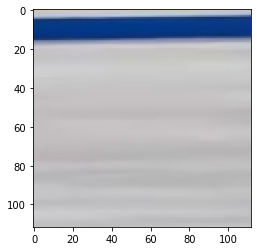

[[[[0.09603534 0.09549167 0.09273291 0.09241685 0.08526652 0.08642554
    0.09022795 0.08295943 0.08534672 0.09920274 0.09389435]]]]


In [ ]:
img,imgModel,re=cropImage(x[0],[100,40,50,140])
imshow(re)
show()
patch = tf.reshape(imgModel, (1, 112, 112, 3))
a_prob = model.call(patch)[0]
print(np.array(a_prob))

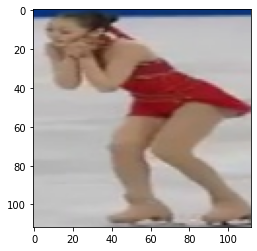

[[[[0.09512234 0.09518623 0.09243257 0.0913996  0.08637986 0.08741564
    0.09024952 0.08443796 0.08509796 0.09874897 0.09352937]]]]


In [ ]:
img,imgModel,re=cropImage(x[0],bbox[0])
imshow(re)
show()
patch = tf.reshape(imgModel, (1, 112, 112, 3))
a_prob = model.call(patch)[0]
print(np.array(a_prob))

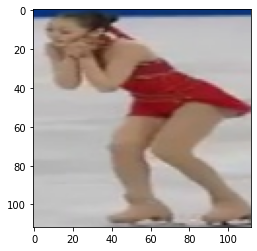

[[[0.08509796]]]
9


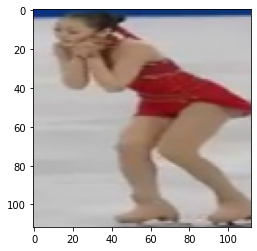

[[[0.08607287]]]
9


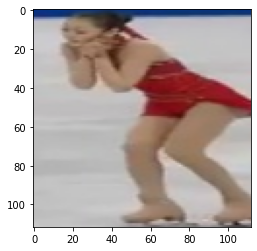

[[[0.08712813]]]
9


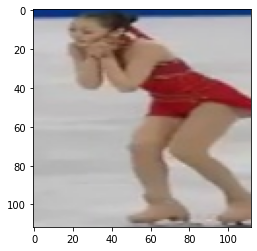

[[[0.08481344]]]
9


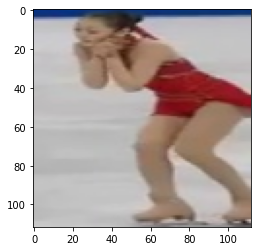

[[[0.08511467]]]
9


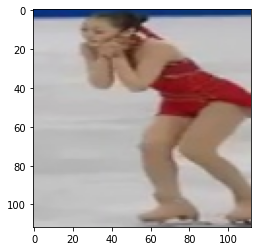

[[[0.08438883]]]
9


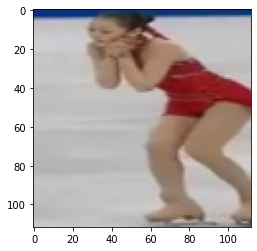

[[[0.0850267]]]
9


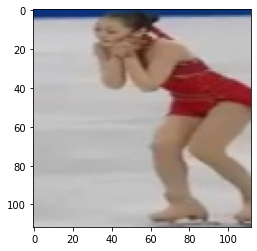

[[[0.08541696]]]
9


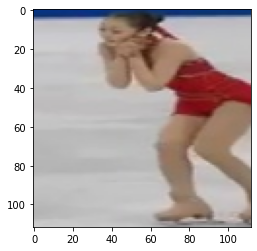

[[[0.08712936]]]
9


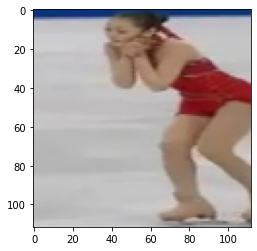

[[[0.08648746]]]
9


In [ ]:
arr=[]
from matplotlib.pyplot import imshow, show    
for i in range(10):
  img,imgModel,re=cropImage(x[0],bbox[i])
  imshow(re)
  show()
  arr.append(imgModel)
  patch = tf.reshape(imgModel, (1, 112, 112, 3))
  a_prob = model.call(patch)[0]
  a, newbbox = selectAction(a_prob, newbbox, np.array(img)) 
  print(np.array(a_prob)[:,:,:,8])
  print(a)